In [1]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy     as np
import time      as clock

/home/ollie/pscholz/tripyview_github


In [ ]:
# from dask.distributed import Client
# from dask.diagnostics import ProgressBar
# import dask

# n_workers=36
# tot_mem  = 100 # GB
# print(' --> memory_limit: {:3.3f} GB'.format(tot_mem/(n_workers+1)))
# dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
# client = Client(n_workers=n_workers, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(tot_mem/n_workers))
# client

In [2]:
# Parameters
# mesh_path = '/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None 
which_mode= 'xmoc_tseries'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_jayne_bin_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'amoc'
year      = [1958,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None # 'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = 0
crange, cmin, cmax, cfac = None, None, None, None

#_____________________________________________________________________________________
do_rescale= None
ncolumn   = 3 
do_allcycl= False
do_concat = False
which_dpi = 300
which_lat = 26.5 # 'max' # 'max', 26.0
which_moc = 'amoc'
do_rapid  = False
do_wbolus = True


In [3]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
                      do_earea=True, do_narea=True, do_eresol=[True,'mean'], do_nresol=[True,'eresol'])

#______________________________________________________________________________________________________
if which_cycl is not None: 
    #__________________________________________________________________________________________________
    if do_allcycl: cycl_s=1
    else         : cycl_s=which_cycl    
    
    #__________________________________________________________________________________________________
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, which_cycl+1):
            # input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name
    
    #__________________________________________________________________________________________________
    if ref_path is not None:
        aux_path, aux_name = list(), list()
        ref_path_old, ref_name_old = ref_path, ref_name
        for ii_cycl in range(cycl_s, which_cycl+1):
            #ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(ref_name))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
            print('R', ref_path[-1])        
        ref_path, ref_name = aux_path, aux_name
    del(aux_path, aux_name)    
    
#______________________________________________________________________________________________________        
cinfo=dict({'cstr':cstr, 'cnum':cnum}) 
if crange   is not None: cinfo['crange']=crange
if cmin     is not None: cinfo['cmin'  ]=cmin
if cmax     is not None: cinfo['cmax'  ]=cmax
if cref     is not None: cinfo['cref'  ]=cref
if cfac     is not None: cinfo['cfac'  ]=cfac   
if ref_path is not None: cinfo['cref'  ]=0.0    
    
#______________________________________________________________________________________________________
# in case of diff plots
if ref_path is not None:
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record  

#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if ref_path is not None: 
    if isinstance(ref_path, list): 
        input_paths, input_names = input_paths + ref_path, input_names + ref_name 
    else:    
        input_paths, input_names = input_paths + list([ref_path]), input_names + list([ref_name])
        
#______________________________________________________________________________________________________
if not isinstance(which_lat, list): which_lat = list([which_lat])
    
#______________________________________________________________________________________________________
if not isinstance(which_lat[0], float) and not isinstance(which_lat[0], int): do_rapid=False
else:    
    if np.abs(which_lat[0]-26.5)>1.0: do_rapid=False

 > found *.pckl file: /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node.pckl
 > comp. e_resol from mean
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________
0 /home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/5/ TKE


In [4]:
aux_vname, aux_vnamebv = 'w', 'bolus_w'
# which_lat = [26.0, 40.0, 'max']
ts = clock.time()
#___LOAD FESOM2 DATA___________________________________________________________________________________    
moctseries_list = list()
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    #____________________________________________________________________________________________________
    # load vertical velocity 
    data = tpv.load_data_fesom2(mesh, datapath, vname=aux_vname, year=year, descript=descript , 
                                do_info=False, do_tarithm=None, do_zarithm=None, do_nan=False, do_compute=False) 
    if do_wbolus: data[aux_vname].data = data[aux_vname].data+tpv.load_data_fesom2(mesh, datapath, vname=aux_vnamebv, year=year, 
                                                                     do_info=False, do_tarithm=None, do_zarithm=None, 
                                                                     do_nan=False, do_compute=False)[aux_vnamebv].data
    
    #____________________________________________________________________________________________________
    # compute moc profile over time
    moc  = tpv.calc_xmoc(mesh, data, dlat=1.0, which_moc=which_moc, do_info=False)

    #____________________________________________________________________________________________________
    # compute time-series
    count=0
    nt    = moc['time'].values.size
    moc_t = np.zeros((nt, len(which_lat)))
    time  = np.zeros((nt,))
    for nti in range(nt):
        #_______________________________________________________________________________________________
        # look for maximum value below 500m at certain latitude or between latitudinal range 'max' 
        # (looks between 30°N and 45°N)
        moc_d=moc.isel(time=nti, nz=moc['depth']<=-500).copy()
        for nli, lat in enumerate(which_lat):
            if lat=='max': moc_t[nti, nli]= moc_d['moc'].isel(ny=(moc_d['lat']>=30) & (moc_d['lat']<=45)).max().values
            else         : moc_t[nti, nli]= moc_d['moc'].isel(ny=np.where(moc_d['lat'].values>=lat)[0][0] ).max().values
        time[nti]=moc['time.year'].values[nti]    
    
    #____________________________________________________________________________________________________
    # moctseries_list.append([time, moc_t])    
    moctseries_list.append(moc_t)    
    del(data, moc, moc_t)
print(' --> elasped time: {} min.'.format( (clock.time()-ts)/60  ))    

/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/5/ TKE
_____calc. AMOC from vertical velocities via meridional bins_____
 --> found diag in directory:{} /home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/1/fesom.mesh.diag.nc
 --> total time:14.911 s
 --> elasped time: 0.3370487570762634 min.


In [5]:
# aux_vname, aux_vnamebv = 'w', 'bolus_w'
# moctseries_list = list()
# year_list       = list(range(year[0], year[1]+1))
# chnk_size       = 20 # compute dmoc time-series in chunks of chnk_size years
# chnk_yrs_list   = year_list[::chnk_size]
# time            = np.array(year_list)
# nt              = time.size
# for datapath, descript in zip(input_paths, input_names): 
#     print(datapath, descript)
    
#     # allocate dmoc timeseries 
#     moc_t = np.zeros((nt, len(which_lat)))
#     print(' > year:', end='')
#     ts = clock.time()
    
#     # compute dmoc time series in chunk of year, to prevent matrices from becoming to big and you run out of memory !!!
#     # you can play with chnk_size for the case you run out of memory 
#     for nchnk, year_s in enumerate(chnk_yrs_list): 
#         year_chnk = [ year_s, np.min([year_s+chnk_size-1,year[1]]) ]  
#         print(*np.arange(year_chnk[0],year_chnk[1]+1), sep='|',end='\n        ')
         
#         #____________________________________________________________________________________________________
#         # load vertical velocity 
#         data = tpv.load_data_fesom2(mesh, datapath, vname=aux_vname, year=year_chnk, descript=descript , 
#                                     do_info=False, do_tarithm=None, do_zarithm=None, do_nan=False, do_compute=False) 
#         data[aux_vname].data = data[aux_vname].data+tpv.load_data_fesom2(mesh, datapath, vname=aux_vnamebv, year=year_chnk, 
#                                                                      do_info=False, do_tarithm=None, do_zarithm=None, 
#                                                                      do_nan=False, do_compute=False)[aux_vnamebv].data

#         #____________________________________________________________________________________________________
#         # compute moc profile over time
#         moc  = tpv.calc_xmoc(mesh, data, dlat=1.0, which_moc=which_moc, do_info=False)
        
#         #____________________________________________________________________________________________________
#         # compute time-series
#         # (looks between 45°N and 60°N when which_lat='max', or at latitude) 
#         nt_chnk = moc['time'].values.size
#         for nti in range(nt_chnk):
#             moc_d=moc.isel(time=nti).copy()
#             for nli, lat in enumerate(which_lat):
#                 if lat=='max': moc_t[(nchnk*chnk_size)+nti, nli]= moc_d['moc'].isel(ny=(moc_d['lat']>=30) & (moc_d['lat']<=45)).max().values
#                 else         : moc_t[(nchnk*chnk_size)+nti, nli]= moc_d['moc'].isel(ny=np.where(moc_d['lat'].values>=lat)[0][0] ).max().values    
        
#         #____________________________________________________________________________________________________
#         del(data, moc)
        
#     #____________________________________________________________________________________________________
#     # moctseries_list.append([time, moc_t])    
#     moctseries_list.append(moc_t)    
#     print('        elapsed time: {:3.2f}min.'.format((clock.time()-ts)/60.0))
#     del(moc_t)

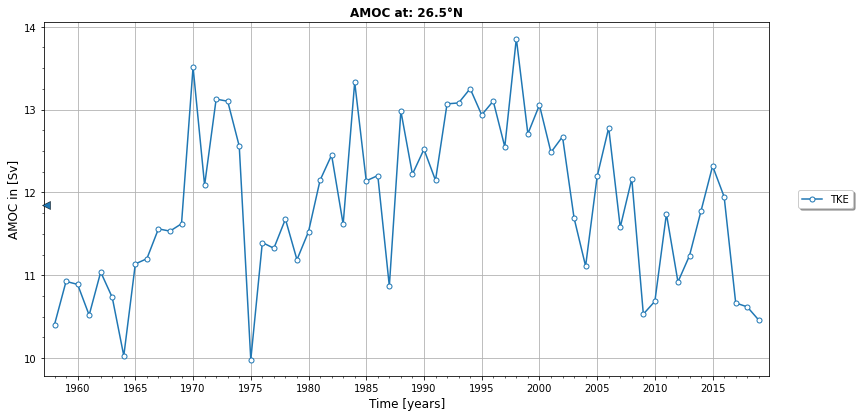

In [6]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = which_moc
if which_lat[0]=='max': slabel='max{:s}_@_30N<=lat<=45N'.format(which_moc.upper(),which_lat[0])
else                  : slabel='{:s}_@_{:2.1f}N'.format(which_moc.upper(),which_lat[0])
if spath is not None: spath  = os.path.join(spath,'{}_{}_{}.png'.format(which_mode, sname, slabel)) 
if save_fname is not None: spath = save_fname
path_rapid = None    
if do_rapid: path_rapid=os.path.join('/home/ollie/pscholz/tripyview_github/data/data_RAPID26.5','moc_transports.nc')
     
fig,ax=tpv.plot_xmoc_tseries(time, moctseries_list, input_names, which_lat=which_lat, which_moc=which_moc, 
                              which_cycl=which_cycl, do_allcycl=do_allcycl, do_concat=do_concat, do_rapid=path_rapid,  
                              do_save=spath, save_dpi=which_dpi, )  